In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

### Inputs

In [2]:
# import gauge info
gauges= pd.read_csv('../../geospacial/misc/hype_naturalized_flows_summary.csv', index_col=0)

In [3]:
gauges

,real_stream_name,USGS_code,DNRC_location
subbasin_id,,,
58328,Beaver Creek (Bowdoin) at Mouth,6166000,6167500
58346,Big Sandy Creek at Mouth,6139500,6139500
58363,Battle Creek at International Boundary,6149500,6149500
58425,Clear Creek at Mouth,6142400,6142400
58290,Frenchman River at International Boundary,6164000,6164000
58356,Lodge Creek at International Boundary,6145500,6145500
58408,Milk River at Western Crossing of Internationa...,6133000,6133000
58643,North Fork Milk River above St. Mary Canal,6133500,6133500
58418,People's Creek at Mouth,6154550,6154550


In [4]:
# import observed flow
qobs= pd.read_csv('../../model/seperate_cal/stmary_cal/data/Qobs.txt',sep='\t',index_col=0)

In [5]:
# import HYPE results
hype_results = pd.read_csv('../../model/combined_cal/06_HYPE_Final/hds_results.csv',index_col=0)

In [6]:
# import depression and drainage area info
depression_area= pd.read_csv('../../geospacial/misc/river_segment_analysis.csv', index_col=0)

In [7]:
# import filepath to usgs gauge data
usgs_filepath= '../../../../IJC_raven_smm/inputs/nat_gauges/USGS/'

### Analysis

In [8]:
# drop the st mary because reconstructing naturalized flows was simple
drop_rows= [58208,58213,58223]

In [9]:
# Set index as int
gauges.index = gauges.index.astype(int)
hype_results.index = hype_results.index.astype(int)
depression_area.index = depression_area.index.astype(int)
# set index as datetime
qobs.index = pd.to_datetime(qobs.index)
# set headers as int
qobs.columns = qobs.columns.astype(int)

In [10]:
# Drop the specified rows from the DataFrame
gauges = gauges.drop(drop_rows, axis=0)

58328 6166000
58346 6139500
58363 6149500
58425 6142400
58290 6164000
58356 6145500
58408 6133000
58643 6133500
58418 6154550
58398 6169500
58308 6135000


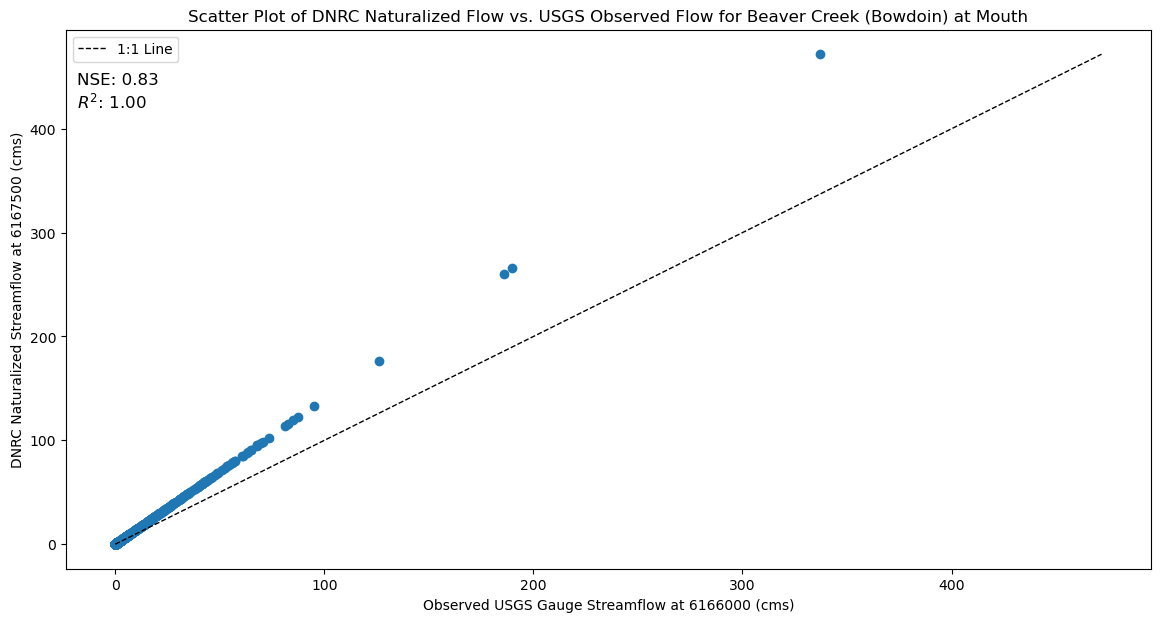

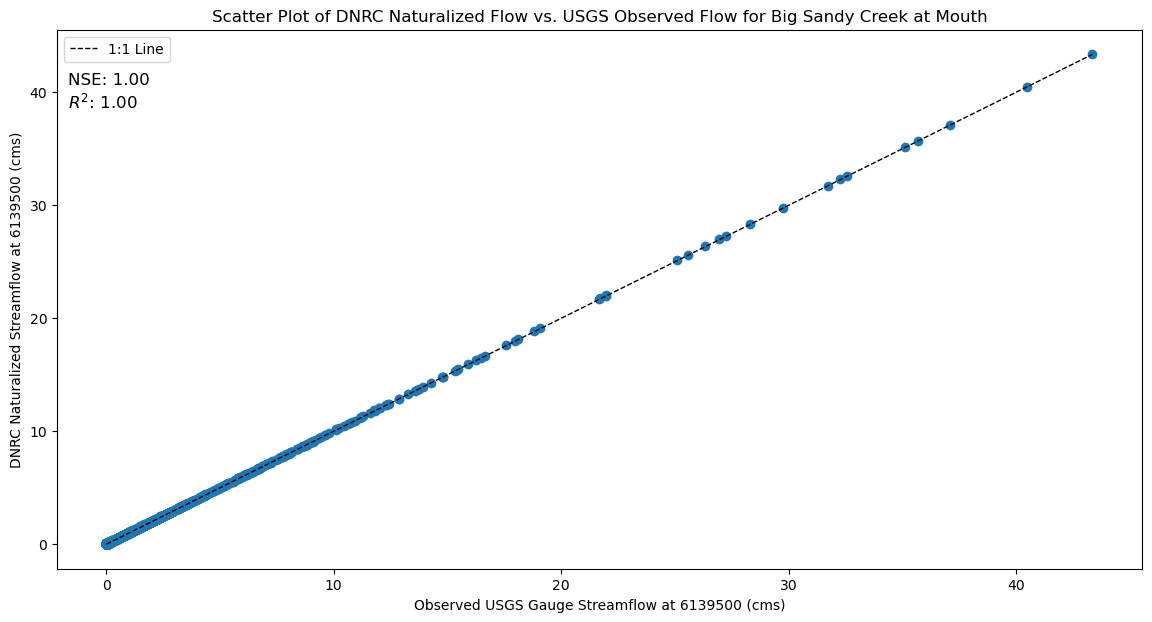

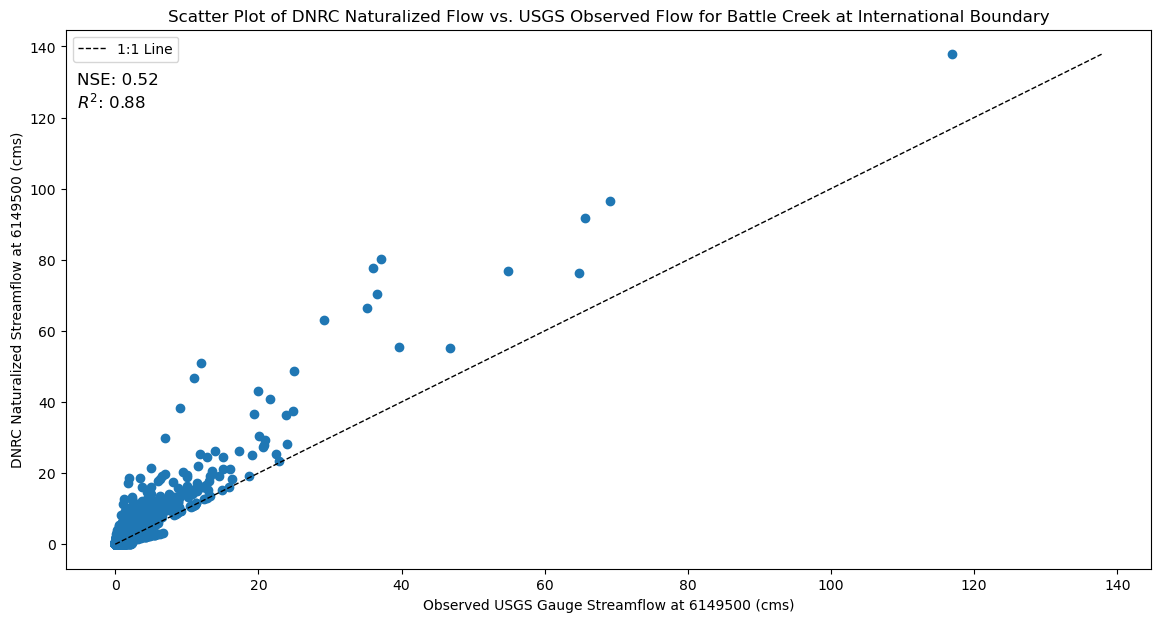

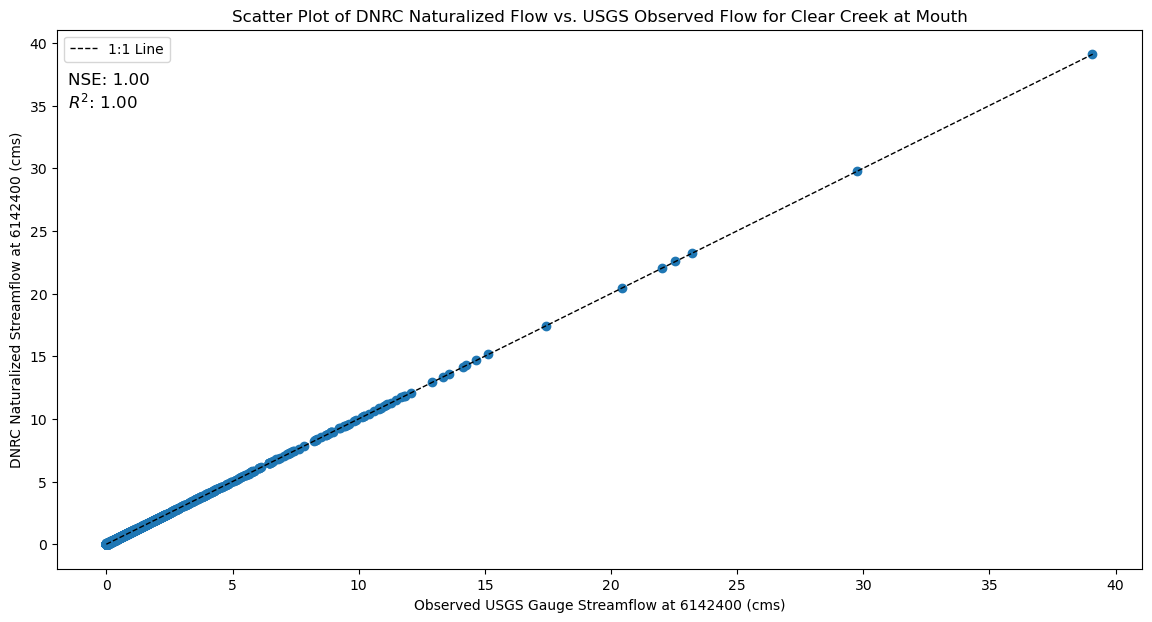

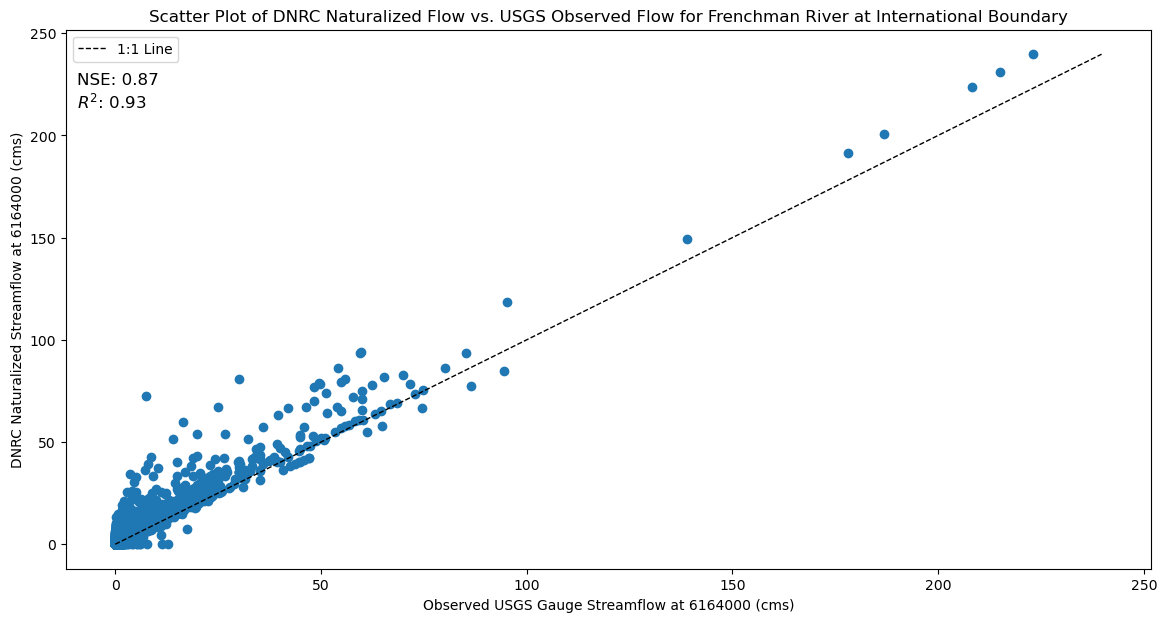

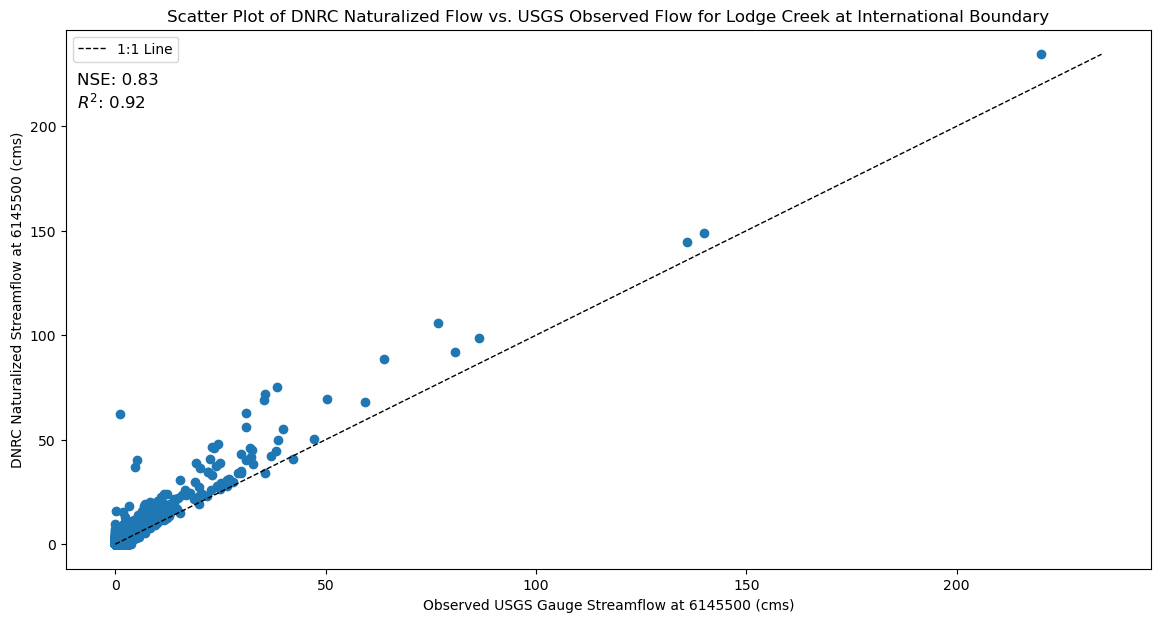

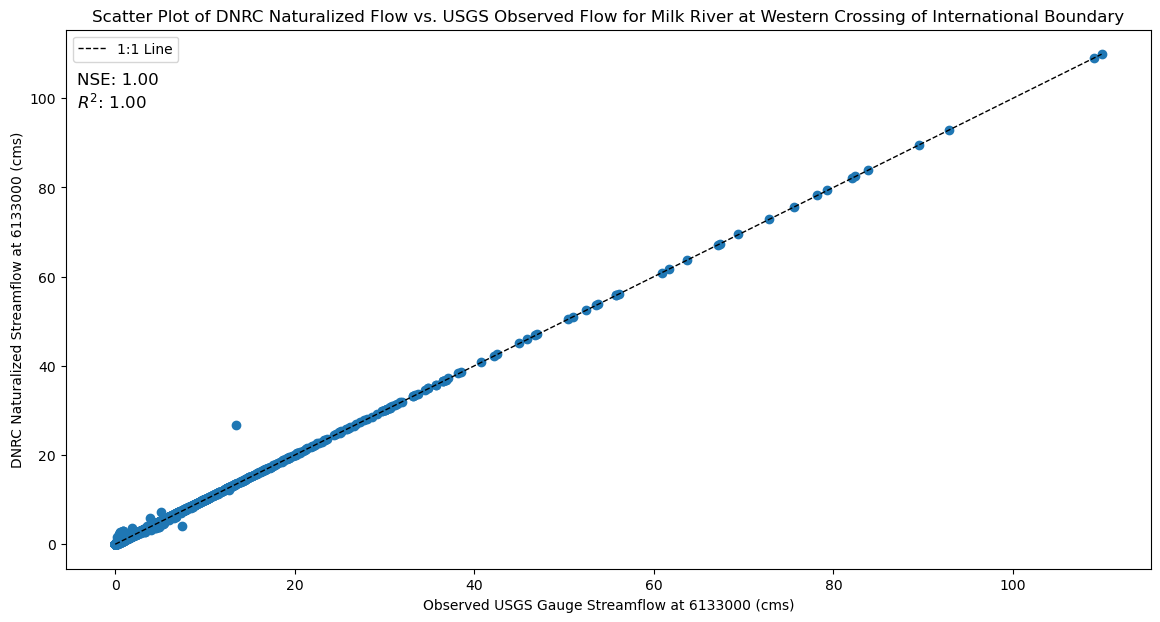

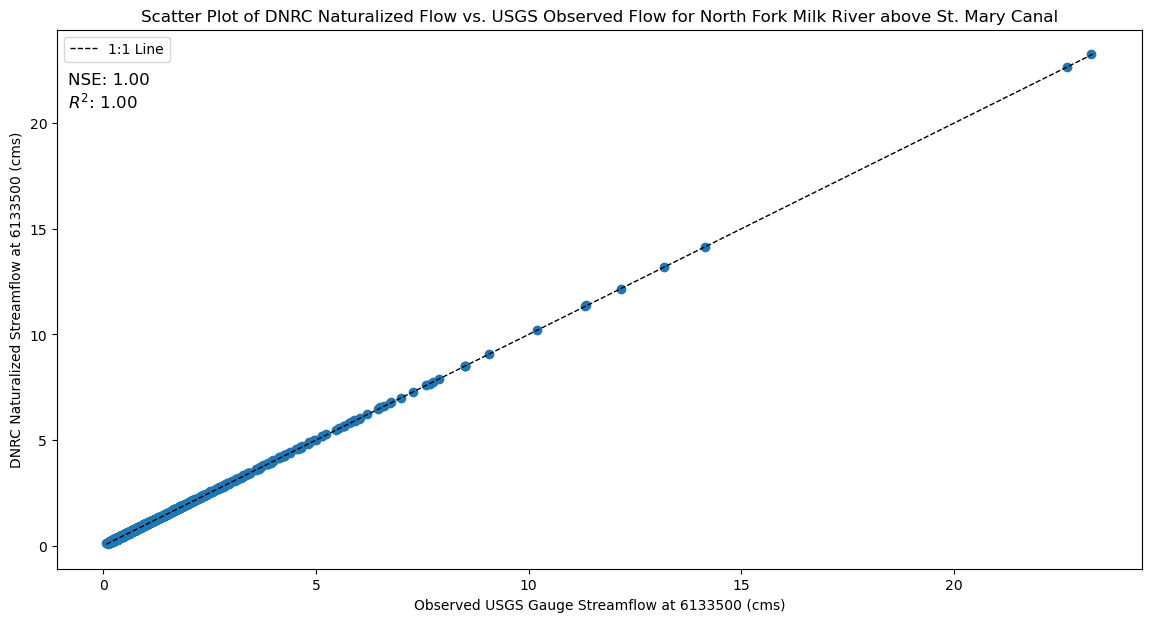

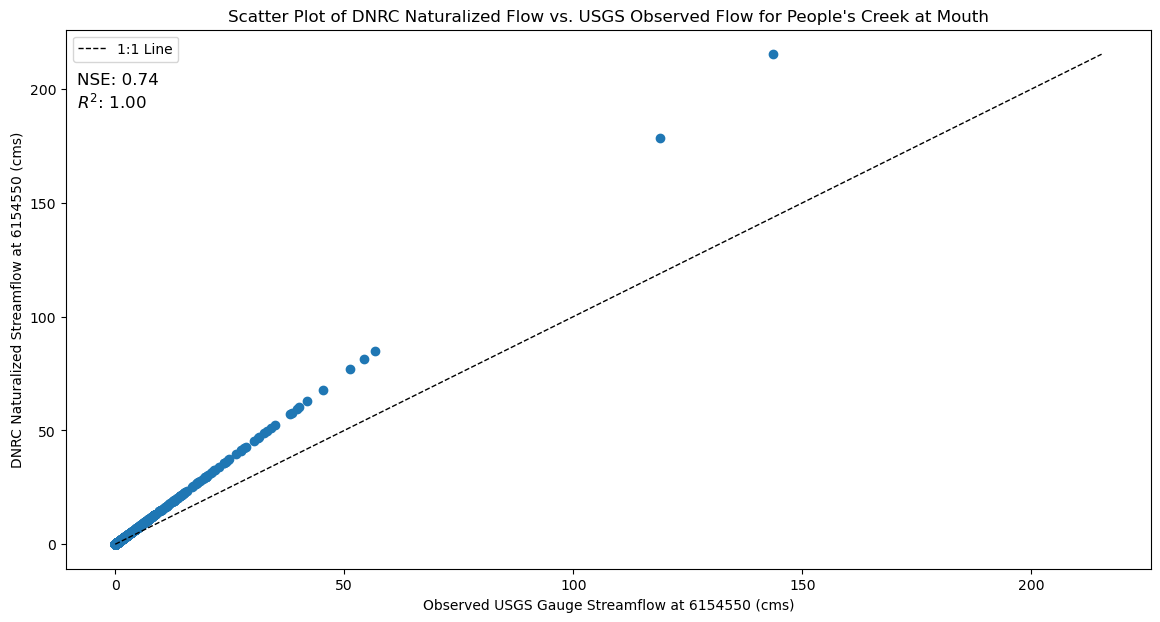

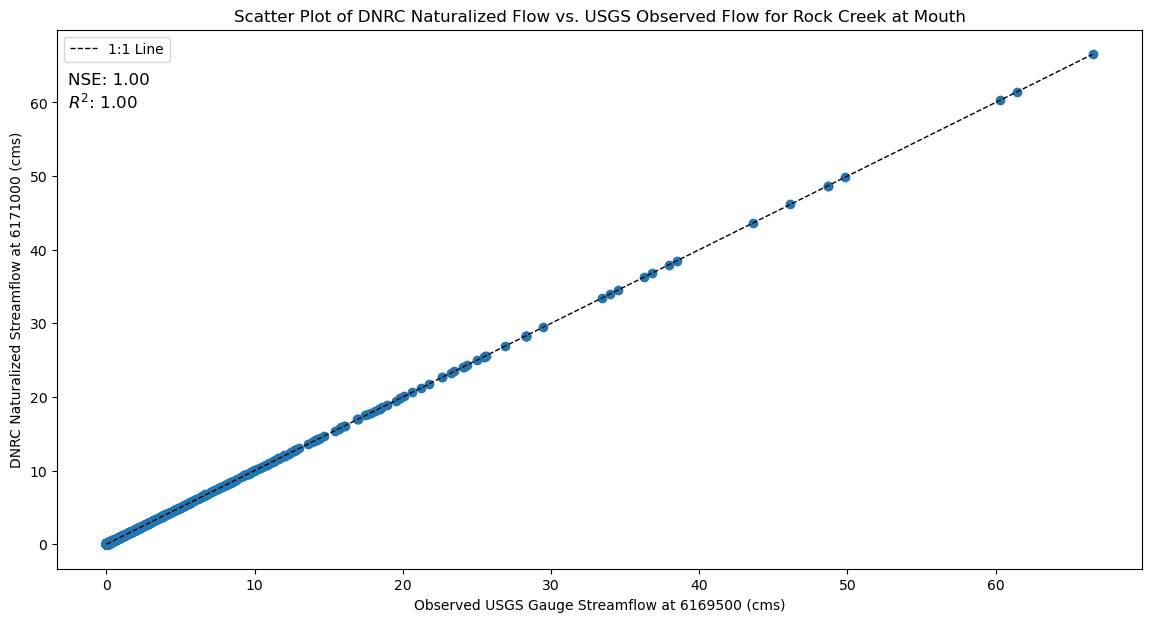

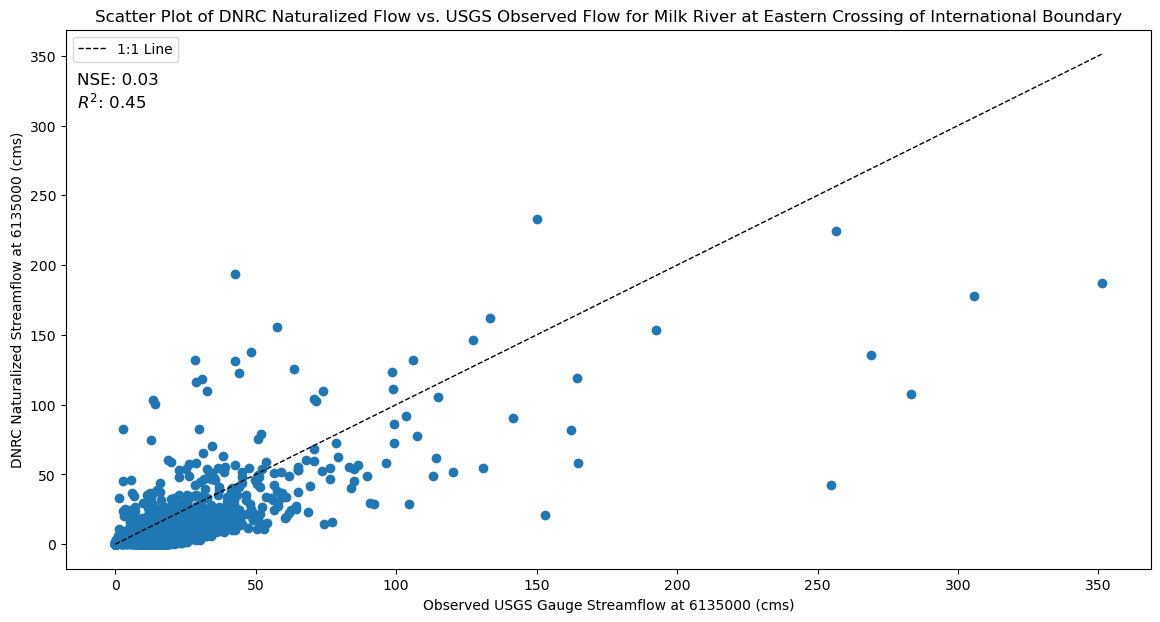

In [11]:
# initialize results list
results = []

# Iterate through the DataFrame index
for idx in gauges.index:
    # Get the USGS_code for the current row
    usgs_code = str(gauges.loc[idx, 'USGS_code'])
    
    real_name = str(gauges.loc[idx, 'real_stream_name'])
    
    dnrc_location = str(gauges.loc[idx, 'DNRC_location'])
    
    # Construct the file path
    file_path = os.path.join(usgs_filepath, f"0{usgs_code}.csv")
    
    print(idx, usgs_code)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the observed flow from the USGS file
        obs = pd.read_csv(file_path, index_col='DATE', parse_dates=True)
        
        # drop all 
        obs= obs[['VALUE']]
        
        # set index as datetime
        obs.index = pd.to_datetime(obs.index)
        
        # Reset the index to make the index a column
        qobs_reset = qobs.reset_index()

        # Rename the index column to something meaningful, e.g., 'DATE'
        qobs_reset.rename(columns={'index': 'Date'}, inplace=True)

        # Create a new DataFrame with only the 'DATE' and 'idx' columns
        nat = qobs_reset[['Date', idx]].copy()
        
        # Convert 'Date' column to datetime if it's not already in DateTime format
        nat['Date'] = pd.to_datetime(nat['Date'])

        # Set 'Date' column as the index
        nat.set_index('Date', inplace=True)
        
        # Merge the 'VALUE' column from 'obs' onto 'compare'
        merged_df = nat.merge(obs[['VALUE']], left_index=True, right_index=True, how='inner')
            
        # Drop rows where any column has a value of -9999
        merged_df = merged_df[(merged_df != -9999).all(axis=1)]
        

        # Drop rows with NA values
        merged_df = merged_df.dropna()

        # Convert the VALUE column from cfs to cms
        merged_df['VALUE'] = merged_df['VALUE'] * 0.0283168

        # Extract the simulated and observed columns
        simulated = merged_df.iloc[:, 0]
        observed = merged_df.iloc[:, 1]
        
            # Calculate the mean of observed values
        mean_observed = observed.mean()

        # Calculate the numerator (sum of squared differences between observed and simulated)
        numerator = np.sum((observed - simulated) ** 2)

        # Calculate the denominator (sum of squared differences between observed and mean observed)
        denominator = np.sum((observed - mean_observed) ** 2)

        # Calculate NSE
        nse = 1 - (numerator / denominator)
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(simulated, observed)

        # Calculate R^2 and round it to two significant figures
        r2 = round(r_value**2, 2)
        
        # Append the results including NSE to the results list
        results.append((idx, nse, r2))
            
        # Set the figure size
        plt.figure(figsize=(14, 7))

        # Create the scatter plot
        plt.scatter(observed, simulated)

        # Draw the 1:1 line and add a label for it
        min_val = min(min(observed), min(simulated))
        max_val = max(max(observed), max(simulated))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line', linewidth=1)

        # Add axis labels with the USGS code
        plt.xlabel(f'Observed USGS Gauge Streamflow at {usgs_code} (cms)')
        plt.ylabel(f'DNRC Naturalized Streamflow at {dnrc_location} (cms)')

        # Add a title with the real name
        plt.title(f'Scatter Plot of DNRC Naturalized Flow vs. USGS Observed Flow for {real_name}')

        # Display the NSE and R^2 values on the plot
        plt.text(0.01, 0.92, f'NSE: {nse:.2f}\n$R^2$: {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

        # Add legend
        plt.legend()

        # Save the plot
        plt.savefig(f'../../model/natflow_analysis/{real_name}_scatter_plot.png', dpi=300, bbox_inches='tight')

In [12]:
results

[(58328, 0.834528678743951, 1.0),
 (58346, 0.9999368545888039, 1.0),
 (58363, 0.5231441212761783, 0.88),
 (58425, 0.9999493544750881, 1.0),
 (58290, 0.8733646213386822, 0.93),
 (58356, 0.830419533148958, 0.92),
 (58408, 0.9987134207506889, 1.0),
 (58643, 0.999285989408054, 1.0),
 (58418, 0.7402350533983507, 1.0),
 (58398, 0.999910324834785, 1.0),
 (58308, 0.025377596530255175, 0.45)]

### Merge Other Data

In [13]:
# Convert the list to a DataFrame
results_df = pd.DataFrame(results, columns=['ID', 'NSE', 'r2'])
# Set 'Date' column as the index
results_df.set_index('ID', inplace=True)

In [14]:
# Merge the 'Cal KGE' column from hype_results onto results_df and rename the column to avoid overwriting
merged_results = results_df.join(hype_results['Cal KGE'].rename('Cal KGE'))

# Merge the 'Cal NSE' column from hype_results onto merged_results and rename the column to avoid overwriting
merged_results = merged_results.join(hype_results['Cal NSE'].rename('Cal NSE'))

In [15]:
merged_results.index = merged_results.index.astype(int)

In [16]:
# Merge the real stream name column from hype_results onto results_df based on the index
merged_results = merged_results.join(gauges['real_stream_name'])

# Merge the real stream name column from hype_results onto results_df based on the index
#merged_results = merged_results.join(hype_results['Drainage Area (km^2)'])

# Merge the real stream name column from hype_results onto results_df based on the index
merged_results = merged_results.join(depression_area['Depression Percentage (%)'])

# Reset the index to make the index a column
merged_results = merged_results.reset_index()
        
# Set 'Date' column as the index
merged_results.set_index('real_stream_name', inplace=True)

### Assign Ranks

In [17]:
# Sort the DataFrame by the 'Cal_KGE' column in descending order
merged_results = merged_results.sort_values(by='Cal KGE', ascending=False)

# Assign ranks: 1 for the highest 'Cal_KGE', n for the lowest
merged_results['Cal KGE Rank'] = range(1, len(merged_results) + 1)

In [18]:
# Sort the DataFrame by the 'Cal_KGE' column in descending order
merged_results = merged_results.sort_values(by='Depression Percentage (%)', ascending=False)

# Assign ranks: 1 for the highest 'Cal_KGE', n for the lowest
merged_results['Depression Rank'] = range(1, len(merged_results) + 1)

In [19]:
# Sort the DataFrame by the 'Cal_KGE' column in descending order
merged_results = merged_results.sort_values(by='NSE', ascending=False)

# Assign ranks: 1 for the highest 'Cal_KGE', n for the lowest
merged_results['NSE Rank'] = range(1, len(merged_results) + 1)

In [20]:
# Sort the DataFrame by the 'Cal_KGE' column in descending order
merged_results = merged_results.sort_values(by='Cal NSE', ascending=False)

# Assign ranks: 1 for the highest 'Cal_KGE', n for the lowest
merged_results['Cal NSE Rank'] = range(1, len(merged_results) + 1)

In [21]:
# Convert the columns to integer type
# merged_results['Drainage Area (km^2)'] = merged_results['Drainage Area (km^2)'].astype(int) 

### Metric Analysis

In [22]:
# Correcting the syntax by properly closing the brackets
nse_analysis = pd.DataFrame(index=merged_results.index, columns=[
    'NSE', 
    'r2',
    'Cal NSE', 
    'Cal KGE', 
 #   'Drainage Area (km^2)', 
    'Depression Percentage (%)'
])

# Optionally, you can populate this DataFrame with data if you have the necessary columns in `merged_results`
nse_analysis['NSE'] = merged_results['NSE']
nse_analysis['r2'] = merged_results['r2']
nse_analysis['Cal NSE'] = merged_results['Cal NSE']
nse_analysis['Cal KGE'] = merged_results['Cal KGE']
#nse_analysis['Drainage Area (km^2)'] = merged_results['Drainage Area (km^2)']
nse_analysis['Depression Percentage (%)'] = merged_results['Depression Percentage (%)']

In [23]:
# Rename the columns in the kge_analysis DataFrame
nse_analysis.rename(columns={
    'NSE': 'Naturalized vs. Observed NSE', 
    'Cal NSE': 'HYPE NSE', 
    'Cal KGE': 'HYPE KGE'
}, inplace=True)

# Rename the index
nse_analysis.index.rename('Gauge Name', inplace=True)

# Save the kge_analysis DataFrame to a CSV file
nse_analysis.to_csv('../../model/natflow_analysis/nse_analysis.csv', index=True)

In [24]:
merged_results

,ID,NSE,r2,Cal KGE,Cal NSE,Depression Percentage (%),Cal KGE Rank,Depression Rank,NSE Rank,Cal NSE Rank
Gauge Name,,,,,,,,,,
Clear Creek at Mouth,58425,0.999949,1.00,0.703891,0.731967,2.648753,3,11,1,1
Big Sandy Creek at Mouth,58346,0.999937,1.00,0.739624,0.541248,11.562326,2,4,2,2
Beaver Creek (Bowdoin) at Mouth,58328,0.834529,1.00,0.746051,0.510322,9.130719,1,6,7,3
Frenchman River at International Boundary,58290,0.873365,0.93,0.553457,0.394535,11.697838,4,3,6,4
Lodge Creek at International Boundary,58356,0.830420,0.92,0.492969,0.259506,12.035570,7,2,8,5
Battle Creek at International Boundary,58363,0.523144,0.88,0.493062,0.216848,15.899041,6,1,10,6
People's Creek at Mouth,58418,0.740235,1.00,0.369850,0.151310,9.209395,9,5,9,7
Milk River at Western Crossing of International Boundary,58408,0.998713,1.00,0.527435,-0.029927,4.526242,5,9,5,8
Milk River at Eastern Crossing of International Boundary,58308,0.025378,0.45,0.423101,-0.081689,8.997143,8,7,11,9


### Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FileNotFoundError: [Errno 2] No such file or directory: '../../model/06_HYPE_Final/nse_vs_kge_scatterplot.png'

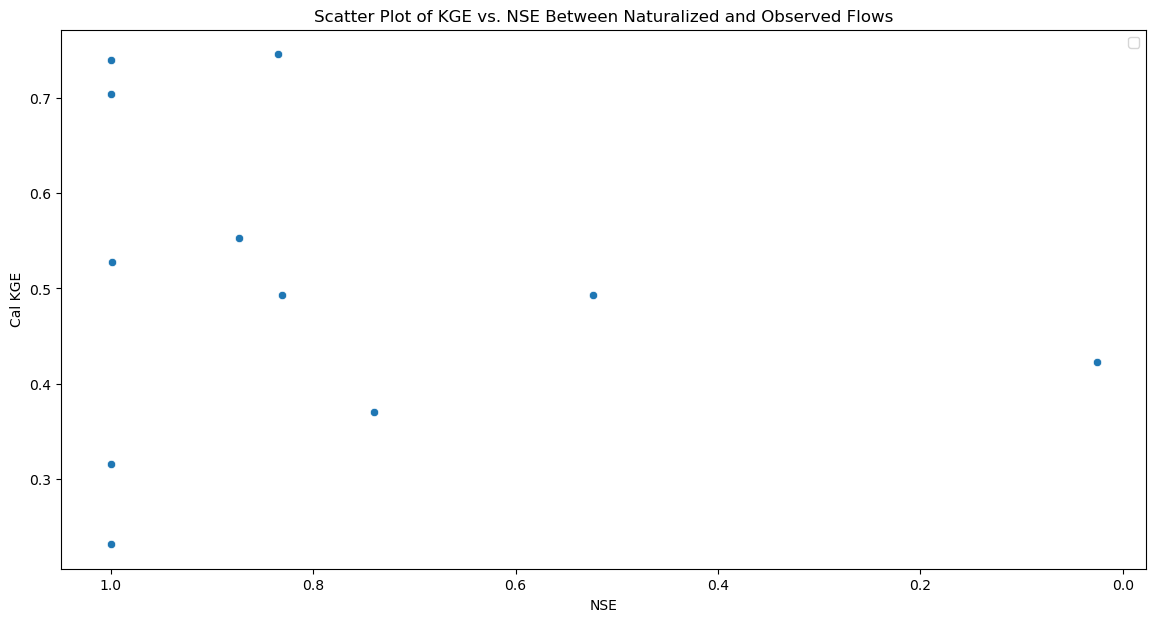

In [25]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(merged_results['NSE'], merged_results['Cal KGE'])

# Calculate R^2
r2 = r_value**2


# Create a scatter plot
plt.figure(figsize=(14, 7))
sns.scatterplot(data=merged_results, x='NSE', y='Cal KGE')

# Plot the regression line
# plt.plot(merged_results['NSE'], slope * merged_results['Cal KGE'] + intercept, color='red', label=f'R^2 = {r2:.2f}')

#plt.xscale('log')
plt.gca().invert_xaxis()

# for idx, row in merged_results.iterrows():
#     label = f"{idx}\nDA (km2): {row['Drainage Area (km^2)']}"
#     plt.text(row['NSE'], row['Cal KGE'], label, fontsize=8, ha='left', va='bottom')

# Add labels and title
plt.xlabel('NSE')
plt.ylabel('Cal KGE')
plt.title('Scatter Plot of KGE vs. NSE Between Naturalized and Observed Flows')
plt.legend()

# Save the plot as a PNG file
plt.savefig('../../model/06_HYPE_Final/nse_vs_kge_scatterplot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()